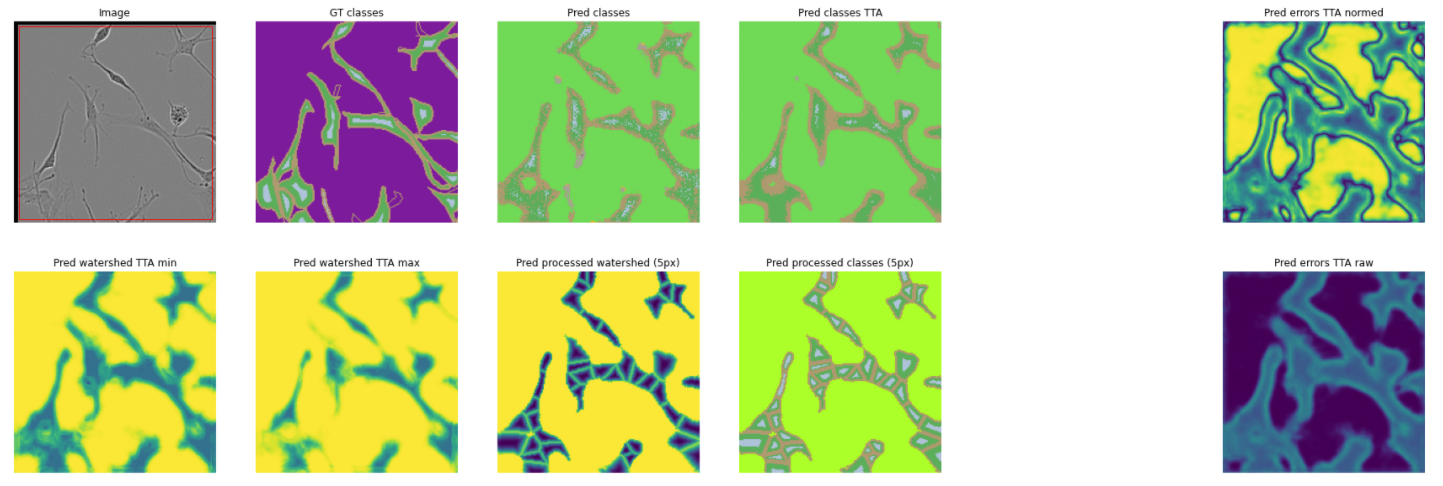

> I have been working on this solution since the very beginning of the competition and until now. I methodically tested ideas and moved forward very slowly because this is painstaking work, and I also have cerebral palsy and it’s physically difficult for me to write any text.
> 
> This is not the final version of the code, I don't even know if it fully works (this is one of hundreds of experiments), but I have to publish it because This morning V. Putin attacked my country and I don't know if I can continue my work. Please, treat with understanding my work, translation inaccuracies and errors in the code. Also, I will be grateful if someone trains the model (at least 50 epochs) and add images with network operation in the comments.


Some reports: https://wandb.ai/green_wizard/Sartorius%20Segmentation

This work has achieved less than 0.15 LB, but here's why I find it useful:

- Detectron2, Mask RCNN, Yolo, etc. are not used. MobileNetV2 is used as a backbone, so as not to waste extra time for pretraining, but this is not even a segmentation model in its original form.

- simple segmentation is used. This, of course, is incorrect, but I am not yet experienced enough to implement something original for instance segmentation.

- the model has less than 1M parameters.

- the work is more of a research nature. Of course, I would like to get into the top 100, but very often I chose a more interesting path, rather than an effective one.

The main disadvantages of my solution, in my opinion:

- It is very difficult for me to express my thoughts in English. Almost everything was translated by Google and rechecked many times, but the text definitely contains typos, incorrectly constructed phrases, etc.

- I'm not good enough at explaining ideas scientifically, with formulas, referring to articles, etc.

- many ideas remained just ideas, many implementation details remained just a good guess. It is important for me to understand why this is so and not otherwise, although I understand that the lack of resources forces me to simply believe that only such a combination works.


---



---



From the very beginning of the competition, I decided NOT to use "normal" approaches. For example, Mask R-CNN can solve the instance segmentation problem well, but this is very boring and, in my opinion, will not give a deep understanding of anything other than fine-tuning the Mask R-CNN. If you prefer standard and understandable solutions, then you better not read further :)

I will try to explain the main points of my code, the reasons for certain decisions. However, I cannot explain everything in too much detail, so feel free to leave your questions in the comments.

And so, let's start with a typical import of all the necessary libraries.

In [ ]:
import os, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2,--xla_gpu_strict_conv_algorithm_picker=false'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_GPU_THREAD_COUNT'] = '1'

IS_COLAB = 'COLAB_GPU' in os.environ
DATASET_PATH = '.' if IS_COLAB else '..'

import cv2

from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math, random
import albumentations as A
import scipy
import skimage

if IS_COLAB:
    from google.colab.patches import cv2_imshow
else:
    def cv2_imshow(img):
        plt.figure(figsize=(10,10))
        plt.imshow(img / 255.0)
        plt.axis('off')
        plt.show()
        return

TRAIN_MODEL = not True
USE_WANDB = IS_COLAB # only in colab?

There are many high-quality EDAs, they describe in detail the nuances of the dataset, analyze each type of cells, and so on, but here's what I think:

- the competition does not require determining the type of cells. Each sample contains only one cell type, so either the training will be unstable or you will need to be very careful in choosing the way to synthesize the combined examples. I do not see reasons for teaching to recognize the type of cells.

- a markup of cell masks is very imprecise and sometimes contains errors.

Taking these into account, I decided to proceed as follows:

- create own classes: core, body and cell boundaries. I just used cv2.distanceTransform for this.

- depending on the distance to the borders of the cells the probability of errors should also change. The inner part of the cells almost always contains the body of the cells, but the boundaries may contain errors. So I decided to generate a pixel-wise weight mask. However, later I found a more interesting approach :)

Also, from the code below, you can see that my model works with 192 * 192 areas and additionally receives 4 pixels to determine the context. In addition, the model predicts watershed energy, which makes it possible to locate cells more accurately.

In [ ]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'input/sartorius-cell-instance-segmentation/train.csv'))

CELL_TYPE = train_df['cell_type'].unique().tolist()
SEG_CLASSES = 1#len(CELL_TYPE)

RAW_INSTANCES = 0
RAW_OVERLAPS = 1 

LAYER_CELL_CORE = 0
LAYER_CELL_BODY = 1
LAYER_CELL_BOUNDS = 2
INNER_CLASSES = 2 # from 0 to INNER_CLASSES
TOTAL_CLASSES = INNER_CLASSES + 1
LAYER_WEIGHTS = TOTAL_CLASSES
LAYER_WATERSHED = LAYER_WEIGHTS + 1

INNER_CROP = 192
OUTER_CROP = INNER_CROP + 8
CROP_PADDING = (OUTER_CROP - INNER_CROP) // 2

BORDER_WIDTH = 2.0
MAX_INNER_WEIGHT = 5.0
MIN_WEIGHT = 0.1
MAX_WEIGHT = 200.0

In [ ]:
GLOBAL_CONFIG = {
  "border_width": BORDER_WIDTH,
  'inner_crop': INNER_CROP,
  'outer_crop': OUTER_CROP,

  'trainer_params': {
      'microBatchSize': 4,
      'useEstimatedErrors': True,
      # can be float or object (i.e. {'min': 0.005, 'max': 0.03})
      # if object then entropy depend on Estimated Errors (or equal to max)
      'entropyTerm': {'min': 0.005, 'max': 0.03},

      'regularization': {
          'active': True,
          'factor': 1e-4,
      }
  },

  'training_params': {
      "batch_size": 4,
      'epochs': 250,
      'max_time': -1,
  },

  'preprocessed channels': 16,
  'mixer_params': {
      'blocks': 3,
      
      'hiddenDim': None,
      'hiddenLayers': 3,
      'dropout': 0.1, 'finalDropout': 0.1,
      'activation': 'gelu',
      
      'mixActivation': 'gelu',
      'scaleInput': False,
      'addToInput': True,

      'innerLayersType': 'conv',
      'convKernelSize': 3,
  },
  'global_mixer': True,
  'mixer_N': 5,

  'output_N': 16,
  'output_N_last': 16,# TOTAL_CLASSES + 1,

  'latent': {
      'channels': 4,
  },
  'skip_connections': False,
  'use EEB extra': True,
  'use WEB extra': True,

  'use_latent_scoring': True,
  'latent_scoring': {
      'layers_N': 3,
      'replicas': 1,
      'preprocess': ['linear', 'softmax'] # 'linear', 'softmax'
  },
}

In [ ]:
import hashlib, json
GLOBAL_CONFIG['config_hash'] = hashlib.sha256(json.dumps(GLOBAL_CONFIG).encode('utf8', errors='ignore')).hexdigest()

# Useful functions and data loaders.

In [ ]:
def replace_with_dict(ar, dic):
  # Extract out keys and values
  k = np.array(list(dic.keys()))
  v = np.array(list(dic.values()))

  # Get argsort indices
  sidx = k.argsort()

  ks = k[sidx]
  vs = v[sidx]
  return vs[np.searchsorted(ks,ar)]

SEG_COLORS = {
  i: matplotlib.colors.to_rgb(x) for i, x in enumerate(matplotlib.colors.XKCD_COLORS)
}

def labels2image(lbl):
  fixed = 1 + ((lbl - 1) % (len(SEG_COLORS) - 1))
  fixed[0==lbl] = 0
  return replace_with_dict(fixed, SEG_COLORS)

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    res = img.reshape(shape)
    # res = scipy.ndimage.morphology.binary_fill_holes(res)
    return res

def bboxBool(np_array):
    result = np.where(np_array)
    x1 = np.min(result[0])
    x2 = np.max(result[0])
    y1 = np.min(result[1])
    y2 = np.max(result[1])
    return x1, y1, x2, y2

def bbox(np_array):
    return bboxBool(0 < np_array)

def build_masks(image_id, bigInstances=False):
    input_shape = (520, 704)
    height, width = input_shape

    data = train_df[train_df["id"] == image_id]
    labels = data["annotation"].tolist()
    cells = data["cell_type"].tolist()

    mask = np.zeros((height, width, SEG_CLASSES), np.uint8)
    overlapped = np.zeros((height, width, 1), np.uint8)
    instances = np.zeros((height, width, 1), np.uint32 if bigInstances else np.uint8)
    validID = set(range(1, 255))
    instID = 1
    for label, cell in zip(labels, cells):
        ind = CELL_TYPE.index(cell) % SEG_CLASSES
        cellMask = rle_decode(label, shape=(height, width, 1))
        x1, y1, x2, y2 = cellBox = bbox(cellMask)
        mask[x1:x2, y1:y2, ind] += cellMask[x1:x2, y1:y2, 0]
        overlapped[x1:x2, y1:y2] += cellMask[x1:x2, y1:y2]
        ######################################
        # instances
        x1, y1, x2, y2 = cellBox
        d = OUTER_CROP
        x1 = max((0, x1 - d))
        y1 = max((0, y1 - d))
        x2 += d
        y2 += d
        
        if not bigInstances:
            instID = min( list(validID - set(np.unique(instances[x1:x2, y1:y2]))) )

        instances[x1:x2, y1:y2][np.where(0 < cellMask[x1:x2, y1:y2])] = instID
        instID += 1
        continue
    
    if bigInstances: return instances
    # overlapped = np.where(overlapped <= 1, 0, 1)
    
    return np.dstack((
        instances.astype(np.uint8), # RAW_INSTANCES
        overlapped.astype(np.uint8), # RAW_OVERLAPS
    ))

In [ ]:
# Additional mask, so that the network is more concentrated on areas close to the boundaries of the analyzed area.
def amplifyMask():
  x_axis = np.linspace(-1, 1, INNER_CROP)
  y_axis = np.linspace(-1, 1, INNER_CROP)
  xx, yy = np.meshgrid(x_axis, y_axis)
  arr = np.sqrt(xx ** 2 + yy ** 2)
  arr /= arr.max()
  return 1 + arr

_ = plt.imshow(amplifyMask())

In [ ]:
def loadGrayscale(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img
    
def supervisedSample(path, im_name):
    img_path = f"{path}/{im_name}.png"
    img = loadGrayscale(img_path)
    mask = build_masks(im_name)
    return img, mask

def unpackInstances(instances, onlyMain=False):
    HW = instances.shape[0]
    s = (HW, HW, 1)
    # build weights map, classes, etc.
    cores = np.zeros(s, np.float32)
    borders = np.zeros(s, np.float32)
    bodies = np.zeros(s, np.float32)
    weights = np.zeros(s, np.float32)
    touching = np.zeros(s, np.uint8)
    EE = np.zeros(s, np.float32)
        
    for id in np.unique(instances):
        if 0 == id: continue

        cellArea = (id == instances)
        x1, y1, x2, y2 = box = bboxBool(cellArea)
        d = 2
        x1 = max((0, x1 - d))
        y1 = max((0, y1 - d))
        x2 += d
        y2 += d
        
        cellArea = cellArea[x1:x2, y1:y2]
        cell = cellArea.astype(np.uint8)

        dist = cv2.distanceTransform(cell, cv2.DIST_L2, 3, dstType=cv2.CV_32F)
        maxD = dist.max()
        assert 0 < maxD
        cellCore = np.logical_and((maxD * (1.0 - 0.3)) < dist, cellArea)
        innerBorders = np.logical_and(dist <= BORDER_WIDTH, cellArea)
        # area between core and borders
        cellBody = np.logical_and(np.logical_not(np.logical_or(cellCore, innerBorders)), cellArea)

        cores[x1:x2, y1:y2][cellCore] = 1
        bodies[x1:x2, y1:y2][cellBody] = 1
        borders[x1:x2, y1:y2][innerBorders] = 1

        dist = dist[..., None]
        EE[x1:x2, y1:y2] = np.maximum(EE[x1:x2, y1:y2], dist / maxD)
        if not onlyMain:
            dist = np.clip(dist, 0.0, MAX_INNER_WEIGHT)
            dist[innerBorders] = maxD

            weights[x1:x2, y1:y2] = np.maximum(weights[x1:x2, y1:y2], dist)

            outterD = cv2.distanceTransform(1 - cell, cv2.DIST_L2, 3, dstType=cv2.CV_32F)
            msk = np.logical_and(outterD < BORDER_WIDTH, np.logical_not(cellArea))
            touching[x1:x2, y1:y2][msk] += 1
        continue

    if not onlyMain:
        binBg = np.where(0 < instances, 0, 1).astype(np.uint8)
        bgDist = cv2.distanceTransform(binBg, cv2.DIST_L2, 3, dstType=cv2.CV_32F)[..., None]
        bgDist = np.clip(bgDist, 0.0, BORDER_WIDTH*2) / BORDER_WIDTH
        weights = np.maximum(weights, bgDist * MAX_WEIGHT)

        fgDist = cv2.distanceTransform(1 - binBg, cv2.DIST_L2, 3, dstType=cv2.CV_32F)[..., None]
        weights = weights * (1 + fgDist) # increase importance of inner areas
        weights = np.clip(weights, MIN_WEIGHT, MAX_WEIGHT)
        weights[1 < touching] = MAX_WEIGHT
        
        weights /= weights.max()
        weights[1 < touching] = 1.0

    EE = np.power(1.0 - EE, 2)
    return np.dstack([cores, bodies, borders, weights, EE])

def unpackSupervisedMasks(masks, amplifyMask=1.0):
    instances = masks[..., RAW_INSTANCES]
    # pack instances id's
    allID = list(sorted(np.unique(instances)))
    if not(0 in allID): # if cell bigger than crop
        allID.insert(0, 0)
    instances = replace_with_dict(instances, {v: i for i, v in enumerate(allID)})

    res = unpackInstances(instances)
    # center crop
    c = OUTER_CROP // 2
    d = INNER_CROP // 2
    res = res[c-d:c+d, c-d:c+d]

    res[..., LAYER_WEIGHTS] *= amplifyMask
    return res

In [ ]:
class CTrainDataloader(tf.keras.utils.Sequence):
    def __init__(self, IDs,
        path='input/sartorius-cell-instance-segmentation/train',
        batch_size=32,
        cropsPerSample=1,
        transform=lambda *x: x,
        minLabeledArea=0.1,
    ):
        self.minLabeledArea = minLabeledArea
        self.transform = transform
        self.batch_size = batch_size
        self.amplifyMask = amplifyMask()
        
        path = os.path.join(DATASET_PATH, path)
        
        N = len(IDs)
        X = []
        Y = []
        for im_name in IDs:
          img, mask = supervisedSample(path, im_name)
          X.append(img[..., None])
          Y.append(mask)
          continue
          
        self._X = np.array(X, np.uint8)
        self._Y = np.array(Y, np.uint8)
        self._indexes = np.arange(math.ceil(N * cropsPerSample / batch_size) * batch_size) % N
        self.on_epoch_end()
        return

    def __len__(self):
        return len(self._indexes) // self.batch_size
        
    def __getitem__(self, index):
        indexes = self._indexes[index*self.batch_size:(index+1)*self.batch_size]

        rawX = self._X[indexes]
        rawY = self._Y[indexes]
        HW = np.array(rawY.shape[:2])

        X = []
        Y = []
        for i, (sampleX, sampleY) in enumerate(zip(rawX, rawY)):
          masks = x = None
          for _ in range(25):
            x, y = self.transform(sampleX, sampleY)
            area = (0 < y[..., RAW_INSTANCES]).sum() / np.prod(y.shape[:2])
            if self.minLabeledArea < area: break
            continue

          X.append(x)
          Y.append(unpackSupervisedMasks(y, self.amplifyMask))
          continue

        return (
            # np.array(X, np.float32) / 255.0,
            np.array(X, np.uint8), # save some memory/time by deriving conversion to trainer
            np.array(Y, np.float32)
        )
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self._indexes)
        return

In [ ]:
def withAugmentations(augm):
    def applyAugm(image, mask):
        tranformed = augm(image=image , mask=mask)
        tranformed_image = tranformed['image']
        tranformed_mask = tranformed['mask']
        return tranformed_image, tranformed_mask
    return applyAugm

In [ ]:
ids = random.choices(train_df['id'].unique().tolist(), k=1)
ids = random.choices(train_df['id'].unique().tolist()[:1], k=1)
testGen = CTrainDataloader(
    ids, cropsPerSample=1,
    transform=withAugmentations(
        A.Compose([
            A.RandomCrop(OUTER_CROP, OUTER_CROP, always_apply=True),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1)),
            A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05),
        ])
    ),
    batch_size=1
)

tmp = None
X, Y = testGen[0]
print(X.shape, Y.shape)
for x, y in zip(X, Y):
    fig, axs = plt.subplots(1, 4, figsize=(6 * 4, 5))
    axs[0].imshow(cv2.cvtColor(x[..., 0], cv2.COLOR_GRAY2BGR))
    axs[0].set_title('image')
    axs[0].axis('off')
    
    cellMask = y[..., :TOTAL_CLASSES]
    c = cellMask.argmax(-1) + np.where(0 < cellMask.max(-1), 1, 0)
    axs[1].imshow(labels2image(c))
    axs[1].set_title('classes')
    axs[1].axis('off')
    
    # print(y[..., LAYER_WEIGHTS].min(), y[..., LAYER_WEIGHTS].max())
    axs[2].imshow(y[..., LAYER_WEIGHTS]/y[..., LAYER_WEIGHTS].max())
    axs[2].set_title('weights')
    axs[2].axis('off')
    
    axs[3].imshow(y[..., LAYER_WATERSHED])
    axs[3].set_title('Watershed')
    axs[3].axis('off')
    # print(np.unique(y[..., :-1].astype(np.int)))
    # break
    

In [ ]:
def cropsFor(W, H, innerCrop=INNER_CROP):
  padding = (OUTER_CROP - innerCrop) // 2
  res = []
  for x in range(padding, W, innerCrop):
    for y in range(padding, H, innerCrop):
      x = min((x, W - innerCrop - padding))
      y = min((y, H - innerCrop - padding))
      res.append((x, y))

  return sorted(set(res))

In [ ]:
class CTestDataloader(tf.keras.utils.Sequence):
    def __init__(self, IDs,
        path='input/sartorius-cell-instance-segmentation/train',
        batch_size=32,
    ):
        self.batch_size = batch_size
        
        path = os.path.join(DATASET_PATH, path)
        X = []
        Y = []
        for im_name in IDs:
            img, mask = supervisedSample(path, im_name)
            paddedImage = cv2.copyMakeBorder(img, CROP_PADDING, CROP_PADDING, CROP_PADDING, CROP_PADDING, cv2.BORDER_CONSTANT, 0)
            paddedMask = cv2.copyMakeBorder(mask, CROP_PADDING, CROP_PADDING, CROP_PADDING, CROP_PADDING, cv2.BORDER_CONSTANT, 0)
            X.append(paddedImage[..., None])
            Y.append(paddedMask)
            continue
          
        self._X = np.array(X, np.uint8)
        self._Y = np.array(Y, np.uint8)

        pW, pH = self._X[0].shape[:2]
        self._crops = cropsFor(pH, pW)
        N = len(self._X) * len(self._crops)
        self._indexes = np.arange(math.ceil(N / batch_size) * batch_size) % N
        return

    def __len__(self):
        return len(self._indexes) // self.batch_size
        
    def __getitem__(self, index):
        indexes = self._indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X = []
        Y = []
        for sample_crop in indexes:
            sampleID = sample_crop // len(self._crops)
            rawX = self._X[sampleID]
            rawY = self._Y[sampleID]

            cropID = sample_crop % len(self._crops)
            (y, x) = self._crops[cropID]

            cropX = rawX[x-CROP_PADDING:x+INNER_CROP+CROP_PADDING, y-CROP_PADDING:y+INNER_CROP+CROP_PADDING]
            cropY = rawY[x-CROP_PADDING:x+INNER_CROP+CROP_PADDING, y-CROP_PADDING:y+INNER_CROP+CROP_PADDING]
            X.append(cropX)
            Y.append(unpackSupervisedMasks(cropY))
            continue

        return (
            np.array(X, np.float32) / 255.0,
            np.array(Y, np.float32)
        )

In [ ]:
ids = random.choices(train_df['id'].unique().tolist(), k=1)
testGen = CTestDataloader(ids)

tmp = None
X, Y = testGen[0]
print(X.shape, Y.shape)
for x, y in zip(X, Y):
    tmp = x
    fig, axs = plt.subplots(1, 4, figsize=(6 * 4, 5))
    axs[0].imshow(cv2.cvtColor(x[..., 0], cv2.COLOR_GRAY2BGR))
    axs[0].set_title('image')
    axs[0].axis('off')
    
    cellMask = y[..., :TOTAL_CLASSES]
    c = cellMask.argmax(-1) + np.where(0 < cellMask.max(-1), 1, 0)
    axs[1].imshow(labels2image(c))
    axs[1].set_title('classes')
    axs[1].axis('off')
    
    axs[2].imshow(y[..., LAYER_WEIGHTS]/y[..., LAYER_WEIGHTS].max())
    axs[2].set_title('weights')
    axs[2].axis('off')
    
    axs[3].imshow(y[..., LAYER_WATERSHED])
    axs[3].set_title('Watershed')
    axs[3].axis('off')
    # print(np.unique(y[..., :-1].astype(np.int)))
    break
    

# Model and trainer

Some basic functions:

In [ ]:
@tf.function(jit_compile=True)
def channelwise(conv):
    return tf.keras.backend.permute_dimensions(conv, (0, 3, 1, 2))

def focalLoss2d(alpha=2.0, beta=4.0):
    def focal_loss(hm_true, hm_pred, W=1.0):
        axis = [1, 2]

        eps = K.epsilon()
        pos_mask = tf.cast(tf.equal(hm_true, 1.0), dtype=tf.float32)
        neg_mask = tf.cast(tf.less(hm_true, 1.0), dtype=tf.float32)
        neg_weights = tf.pow(1.0 - hm_true, beta)

        pos_loss = (
          -tf.math.log(tf.clip_by_value(hm_pred, eps, 1.0 - eps))
          * tf.math.pow(1.0 + eps - hm_pred, alpha)
          * pos_mask
          * W
        )
        neg_loss = (
            -tf.math.log(tf.clip_by_value(1.0 - hm_pred, eps, 1.0 - eps))
            * tf.math.pow(hm_pred + eps, alpha)
            * neg_weights
            * neg_mask
            * W
        )
        tf.assert_equal(tf.shape(pos_loss), tf.shape(hm_true))
        tf.assert_equal(tf.shape(neg_loss), tf.shape(hm_true))

        num_pos = tf.reduce_sum(pos_mask, axis=axis)
        pos_loss = tf.reduce_sum(pos_loss, axis=axis)
        neg_loss = tf.reduce_sum(neg_loss, axis=axis)

        lossNonZero = tf.math.divide_no_nan(pos_loss + neg_loss, num_pos)
        return tf.where(0 < num_pos, lossNonZero, neg_loss)
    return focal_loss
    
@tf.function(jit_compile=True)
def iou_coef(y_true, y_pred, smooth=1, axis=[1, 2, 3]):
    intersection = K.sum(K.abs(y_true * y_pred), axis=axis)
    union = K.sum(y_true, axis) + K.sum(y_pred, axis) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

@tf.function(jit_compile=True)
def JensenShannonDivergence(p, q):
    m = (p + q) / 2.0
    return (tf.losses.kl_divergence(p, m) + tf.losses.kl_divergence(q, m)) / 2.0

@tf.function(jit_compile=True)
def diceLoss(y_true, y_pred):
    axes = (1, 2) # [batch dim] + [1, 2] + [classes]
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    dice = numerator / (denominator + K.epsilon())
    return 1.0 - dice

def createTiles(tile_size):
    def _tile(images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, tile_size, tile_size, 1],
            strides=[1, tile_size, tile_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, tile_size, tile_size])
        return tf.transpose(patches, (0, 2, 3, 1))
      
    def apply(images):
        imagesShape = images.get_shape().as_list()
        batch_size = tf.shape(images)[0]
        H, W, channels = imagesShape[1:]
        N = (H // tile_size) ** 2

        inner = _tile(images[:, :-1, :-1, :])
        bottom = _tile(images[:, :-1, -tile_size:])
        right = _tile(images[:, -tile_size:, :-1])
        corner = images[:, -tile_size:, -tile_size:, :]
        patches = tf.concat([inner, bottom, right, corner], axis=-1)
        return tf.reshape(patches, [tf.shape(images)[0], tile_size, tile_size, channels * (math.ceil(H / tile_size) * math.ceil(W / tile_size))])
    return apply

@tf.function(jit_compile=True)
def normalizeTensor(x, axis):
    mean = tf.reduce_mean(x, axis=axis, keepdims=True)
    std = tf.math.reduce_std(x, axis=axis, keepdims=True)
    return tf.math.divide_no_nan(x - mean, std)
    
@tf.function(jit_compile=True)
def normalizeTensorRange(x, axis):
    Max = tf.reduce_max(x, axis=axis, keepdims=True)
    Min = tf.reduce_min(x, axis=axis, keepdims=True)
    return tf.clip_by_value(
        tf.math.divide_no_nan(x - Min, Max - Min),
        clip_value_min=0.0, clip_value_max=1.0
    )
    
@tf.function(jit_compile=True)
def topKMaskChannelwise(x, k):
    values, _ = tf.nn.top_k(
        tf.reshape( tf.transpose(x, (0, 3, 1, 2)), (tf.shape(x)[0], tf.shape(x)[-1], -1)),
        k=k
    ) # B x N x k
    values = values[..., -1][:, None, None, :] # B x N x k => B x 1 x 1 x N
    return tf.cast(values <= x, tf.float32)
    
@tf.function(jit_compile=True)
def normAttention(x):
    x = normalizeTensor(x, axis=(1, 2))
    l = tf.where(x < 0.0, -x, 0.0)
    h = tf.where(x > 0.0, x, 0.0)
    return tf.clip_by_value(
        normalizeTensorRange(l, axis=(1, 2)) + normalizeTensorRange(h, axis=(1, 2)),
        clip_value_min=0.0, clip_value_max=1.0
    )
    
def reduceMinMax(tensors):
    maxV = minV = tensors[0]
    for x in tensors[1:]:
        maxV = tf.maximum(x, maxV)
        minV = tf.minimum(x, minV)
        continue

    return [minV, maxV]

class FakeObject(object):
    def __init__(self, data):
        for name, value in data.items():
            setattr(self, name.replace(' ', '_'), value)
            continue
        return

def SG(x):
    return tf.keras.layers.Lambda(tf.stop_gradient)(x)

def flatTensor(x):
  return tf.reshape(x, (tf.shape(x)[0], -1))

In [ ]:
def layerwiseSoftmax(x):
    s = tf.shape(x)
    x = tf.transpose(x, (0, 3, 1, 2))
    x = tf.reshape(x, (s[0], s[3], -1))
    x = tf.nn.softmax(x, axis=-1)
    x = tf.reshape(x, (s[0], s[3], s[1], s[2]))
    x = tf.transpose(x, (0, 2, 3, 1))
    x = tf.clip_by_value(x, 0.0, 1.0) # prevent NaN, when all values in layer is same/zero
    return x

class LayerwiseSoftmaxLayer(tf.keras.layers.Layer):
    def call(self, data):
        return layerwiseSoftmax(data)

This layer provides additional information to the network. The network, of course, can learn these transformations, but this will require additional "capacity" of the network (in the form of weights and/or layers), therefore, it is better to initially provide the data in a form that the network may find useful.

In [ ]:
class PrepareImagesLayer(tf.keras.layers.Layer):
    def __init__(self, channels=1, activation='tanh', F=None):
        super().__init__()
        self._compress = tf.keras.layers.Dense(channels, activation=activation)
        self._F = F if not(F is None) else lambda x: x
        return

    def _process(self, images):
        res = [images]
        res.append(tf.image.sobel_edges(images)[..., 0, :])
        for factor in [0.1, 0.5, 2.0, 5.0, 20.0]:
            img = tf.image.adjust_contrast(images, factor)
            res.append(img)
            res.append(tf.image.sobel_edges(img)[..., 0, :])
            continue

        res = tf.concat(res, axis=-1)
        res = tf.stop_gradient(res)
        return self._compress(res)

    def call(self, images):
        images = self._F(images)
        return self._process(images)

This is probably the strangest part of my code. I was thinking about using MLP-Mixer, but I quickly realized that this is not what I want. MLP-Mixer allows very complex data manipulations, it can have a huge perception field. However, MLP-Mixer only changes the input based on the same data, but I wanted to change it based on "external" data as well.

This block turned out to be so complex, since each of its variants has a very significant effect not only on the final accuracy of the model, but also on the properties of the features. 

In [ ]:
@tf.function(jit_compile=True)
def relativeSoftmax(x):
    x = tf.nn.softmax(x, axis=-1)
    return x - tf.reduce_mean(x, axis=-1, keepdims=True)

class StrangeMixerLayer(tf.keras.layers.Layer):
    def __init__(self,
                 blocks=1,
                 hiddenDim=None,
                 hiddenLayers=0,
                 dropout=0.05, finalDropout=0.05,
                 activation='gelu',
                 mixActivation='gelu',
                 innerLayersType='dense', convKernelSize=1,
                 scaleInput=False,
                 addToInput=True
    ):
        super().__init__()

        self._dropout = tf.keras.layers.Dropout(dropout, name='dropoutA') if 0.0 < dropout else lambda x: x
        self._finalDropout = tf.keras.layers.Dropout(finalDropout, name='dropoutB') if 0.0 < finalDropout else lambda x: x
        self._activation = activation
        self._hidden = hiddenDim
        self._blocks = blocks
        self._scaleInput = scaleInput
        self._addToInput = addToInput
        self._hiddenLayers = hiddenLayers

        if 'relativeSoftmax' == mixActivation: # small hack
            mixActivation = relativeSoftmax
        self._mixActivation = mixActivation

        self._innerLayersType = innerLayersType.lower()
        assert self._innerLayersType in ['dense', 'conv']
        self._convKernelSize = convKernelSize
        return

    def build(self, input_shape):
        *_, H, W, N = input_shape

        LKind = None
        if 'conv' == self._innerLayersType:
            args = {'activation': self._activation, 'padding': 'same', 'kernel_size': self._convKernelSize}
            LKind = tf.keras.layers.Conv2D

        if 'dense' == self._innerLayersType:
            args = {'activation': self._activation}
            LKind = tf.keras.layers.Dense
        #####################
        hidden = self._hidden if not (self._hidden is None) else H
        self._mix1L = tf.keras.Sequential([
            # LayerwiseSoftmaxLayer(name='%s/mix1-norm' % self.name),
            *[LKind(hidden, **args, name='%s/mix1-L%d' % (self.name, ind)) for ind in range(self._hiddenLayers)],
            LKind(H, **args, name='%s/mix1-last' % self.name)
        ], name='%s/mix1' % self.name)

        hidden = self._hidden if not (self._hidden is None) else W
        self._mix2L = tf.keras.Sequential([
            # LayerwiseSoftmaxLayer(name='%s/mix2-norm' % self.name),
            *[LKind(hidden, **args, name='%s/mix2-L%d' % (self.name, ind)) for ind in range(self._hiddenLayers)],
            LKind(W, **args, name='%s/mix2-last' % self.name)
        ], name='%s/mix2' % self.name)

        hidden = self._hidden if not (self._hidden is None) else N
        self._mix3 = tf.keras.Sequential([
            # LayerwiseSoftmaxLayer(name='%s/mix3-norm' % self.name),
            *[LKind(hidden, **args, name='%s/mix3-L%d' % (self.name, ind)) for ind in range(self._hiddenLayers)],
            LKind(N, **args, name='%s/mix3-last' % self.name)
        ], name='%s/mix3' % self.name)
        
        self._mix1A = LKind(N, **args, name='%s/mix1-after' % self.name)
        self._mix2A = LKind(N, **args, name='%s/mix2-after' % self.name)

        args['activation'] = self._mixActivation
        self._mixF = tf.keras.Sequential([
            # LayerwiseSoftmaxLayer(name='%s/mixFinal-norm' % self.name),
            LKind(N, **args, name='%s/mixFinal-last' % self.name)
        ], name='%s/mixFinal' % self.name)
        return

    def _mix1(self, x):
        N = len(tf.shape(x))
        tail = list(range(N - 3))
        transposeForward = tail + [N - 1, N - 2, N - 3] # ....HWC => ....CWH
        transposeBackward = tail + [N - 1, N - 2, N - 3] # ....CWH => ....HWC

        x = tf.transpose(x, transposeForward)
        x = self._mix1L(x)
        x = tf.transpose(x, transposeBackward)
        return self._mix1A(x)

    def _mix2(self, x):
        N = len(tf.shape(x))
        tail = list(range(N - 3))
        transposeForward = tail + [N - 1, N - 3, N - 2] # ....HWC => ....CHW
        transposeBackward = tail + [N - 2, N - 1, N - 3] # ....CHW => ....HWC

        x = tf.transpose(x, transposeForward)
        x = self._mix2L(x)
        x = tf.transpose(x, transposeBackward)
        return self._mix2A(x)

    def _finalMix(self, A, B, C, mixes):
        allMix = tf.concat([*mixes], -1)
        allMix = self._finalDropout(allMix)
        return self._mixF(allMix)
        
    def _apply(self, A, B):
        C = tf.concat([A, B], axis=-1)
        mixers = [self._mix1, self._mix2, self._mix3]
        mixes = [f(self._dropout(C)) for f in mixers]
        return self._finalMix(A, B, C, mixes)

    @tf.function(jit_compile=True)
    def call(self, *inputs):
        A, *other = inputs
        B = tf.concat(other, axis=-1) if 1 < len(other) else other[0]
        
        for i in range(self._blocks):
            C = self._apply(A, B)
            if self._scaleInput:
                C = A * C
            if self._addToInput:
                C = A + C
            A = C
            continue
        return A

I use MobileNetV2 as backbone for feature extraction, enriching them with additional information. I do not use the smallest features (block_15_project), since it only increases the final size of the model, slows down the training, but not much improves accuracy.

In [ ]:
def _featuresProvider(shape):
    assert np.array_equal(shape, (192, 192, 3))
    base_model = None
    if IS_COLAB:
        base_model = tf.keras.applications.MobileNetV2(input_shape=shape, include_top=False)
        base_model.save_weights('backbone.h5')
    else: # kaggle
        base_model = tf.keras.applications.MobileNetV2(input_shape=shape, include_top=False, weights=None)
        base_model.load_weights('../input/backbone/backbone.h5')
    # Use the activations of these layers
    layer_names = [
      'block_1_expand_relu',
      'block_3_expand_relu',
      'block_5_project',
      'block_8_project',
      # 'block_15_project',
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extraction model
    model = tf.keras.Model(inputs=base_model.input, outputs=layers)
    model.trainable = False
    return model

# from tensorflow_examples.models.pix2pix import pix2pix
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.

    Conv2DTranspose => Batchnorm => Dropout => Relu

    Args:
      filters: number of filters
      size: filter size
      norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
      apply_dropout: If True, adds the dropout layer

    Returns:
      Upsample Sequential Model
    """

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5)),

    result.add(tf.keras.layers.ReLU())
    return result

def PreprocessImageBlock(outputN, extraN, hidden=None):
    hidden = hidden if not(hidden is None) else outputN
    images = tf.keras.layers.Input(shape=(INNER_CROP, INNER_CROP, 1))
    extra = tf.keras.layers.Input(shape=(OUTER_CROP, OUTER_CROP, extraN))
    
    featuresNet = _featuresProvider(shape=(INNER_CROP, INNER_CROP, 3))
    rgb = tf.image.grayscale_to_rgb(images)
    features = featuresNet((2.0 * rgb) - 1.0)[::-1]

    res = None
    heatmaps = []
    for FV in features:
      resized = tf.keras.layers.Lambda(createTiles(FV.shape[1]))(extra)

      parts = [resized, FV]
      if not(res is None):
        parts.append(res)
      
      concatenated = res = tf.keras.layers.Concatenate(axis=-1)(parts)
      heatmaps.append(tf.keras.layers.Conv2D(hidden, 3, padding='same', activation='relu')(
          tf.keras.layers.Dropout(0.05)(res)
      ))
      res = upsample(hidden, 3, apply_dropout=True)(concatenated)
      continue

    def dummyConv(x):
        for i in range(3):
            x = tf.keras.layers.Conv2D(hidden, 3, padding='same', activation='relu')(x)
        return x

    heatmaps.append(dummyConv(res))
    heatmaps.append(dummyConv(images))
    heatmaps.append(dummyConv(
        tf.keras.layers.Lambda(createTiles(INNER_CROP))(extra)
    ))
    combined = tf.keras.layers.Add()(
        [tf.keras.layers.experimental.preprocessing.Resizing(INNER_CROP, INNER_CROP)(x) for x in heatmaps]
    )
    res = tf.keras.layers.Conv2D(outputN, 3, padding='same', activation='relu')(tf.keras.layers.Dropout(0.1)(combined))
    res = tf.keras.layers.Conv2D(outputN, 1, padding='same', activation='relu')(res)
    return keras.Model(inputs=[images, extra], outputs=[res])

`HeatmapGenerationBlock` had to be implemented as an autoencoder. You see, I wanted to do most of the work in latent space using the autoregressive approach and `StrangeMixerLayer`, but this requires a lot of memory. In addition, I used something like a latent discriminator and it is not known how it will behave if some of the information goes through skip-connections.

I did several experiments without a discriminator and with skip-connections (making them very noisy (95% dropout) so that most of the information goes through the latent space and `StrangeMixerLayer`). This increased learning speed and accuracy, but I'm more interested in learning something new.

In [ ]:
def LatentSpaceEvaluator(latentShape, conditionShape):
    latent = tf.keras.layers.Input(shape=latentShape)
    cond = tf.keras.layers.Input(shape=conditionShape)
    
    evaluated = latent
    stages = [evaluated]

    if GLOBAL_CONFIG['global_mixer']:
        mixer = StrangeMixerLayer(**GLOBAL_CONFIG['mixer_params'])
    else:
        mixer = lambda *args: StrangeMixerLayer(**GLOBAL_CONFIG['mixer_params'])(*args)
        
    for _ in range(GLOBAL_CONFIG['mixer_N']):
        evaluated = mixer(evaluated, cond)
        stages.append(evaluated)
        continue

    return keras.Model(inputs=[latent, cond], outputs=stages)

def HGMDecoder(shapeA, pool):
    outputN = GLOBAL_CONFIG['output_N']
    useSkips = GLOBAL_CONFIG['skip_connections']
    
    decoderInput = tf.keras.layers.Input(shapeA)
    skipConnections = []
    decodingHM = None
    prevState = decoderInput
    for stepIndex, SCShape in enumerate(pool):
        decodingHM = prevState

        data = [decodingHM]
        if useSkips:
            skipConnections.append(tf.keras.layers.Input(SCShape))
            # 0.95 - not a typo
            data.append(tf.keras.layers.Dropout(0.95)(skipConnections[-1]))

        decodingHM = tf.keras.layers.Conv2D(outputN, 3, padding='same', activation='relu')(
            tf.keras.layers.Concatenate(axis=-1)(data) if 1 < len(data) else data[0]
        )
        for _ in range(3):
            decodingHM = tf.keras.layers.Conv2D(outputN, 3, padding='same', activation='relu')(decodingHM)
        ########
        prevState = tf.keras.layers.Conv2DTranspose(outputN, 3, padding='same', activation='relu', strides=2)(
            tf.keras.layers.Dropout(0.05)(decodingHM)
        )
        continue

    decodingHM = tf.keras.layers.Conv2D(
        GLOBAL_CONFIG.get('output_N_last', outputN), 
        kernel_size=3, padding='same', activation='softmax'
    )(decodingHM)
    return tf.keras.Model(inputs=[decoderInput] + skipConnections, outputs=[decodingHM])

def HeatmapGenerationBlock(inputShape, extraShape):
    encodedImages = tf.keras.layers.Input(shape=inputShape)
    extra = tf.keras.layers.Input(shape=extraShape)

    channels = inputShape[-1]
    encoded = tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu')(
        tf.keras.layers.Dropout(0.05)(encodedImages)
    )

    extraData = extra
    pool = [tf.keras.layers.Concatenate(axis=-1)([encoded, extraData])]
    # downsample
    for _ in range(3):
        extraData = tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu', strides=2)(
            tf.keras.layers.Dropout(0.05)(extraData)
        )
        encoded = tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu', strides=2)(
            tf.keras.layers.Dropout(0.05)(encoded)
        )
        pool.append(tf.keras.layers.Concatenate(axis=-1)([encoded, extraData]))
        continue
    # evaluate in latent space
    latent = tf.keras.layers.Conv2D(GLOBAL_CONFIG['latent']['channels'], 3, padding='same', activation='relu')(encoded)
    condition = tf.keras.layers.Concatenate(axis=-1)([encoded, extraData])

    evaluator = LatentSpaceEvaluator(latentShape=latent.shape[1:], conditionShape=condition.shape[1:])
    stages = evaluator([latent, condition])
    ##############################
    heatmaps = stages[-1]
    pool = pool[::-1]
    decoder = HGMDecoder(heatmaps.shape[1:], [x.shape[1:] for x in pool])
    decoderData = [heatmaps]
    skipConnections = []
    if GLOBAL_CONFIG['skip_connections']:
        decoderData.extend(pool)
        skipConnections = pool
    
    return(
        keras.Model(inputs=[encodedImages, extra], outputs={
            'heatmaps': decoder(decoderData),
            'latent condition': condition,
            'latent stages': stages,
            'skip_connections': skipConnections
        }),
        evaluator,
        decoder
    )

It's finally time to put all the parts of the detector together. Could there be something strange here? Well, I wouldn't be me if not.

At some point, I asked myself "Can the network predict where it will make mistakes?". If we can take a picture and estimate the probability of belonging to a certain class, then we can take features from the inner layer of the network and estimate the probability of errors. Of course, we cannot allow the estimation process to affect the main work, so I stop the flow of gradients. I had a lot of concerns about this idea, but experiments have shown that this approach works quite well.

How can error estimation be used? In addition to being used in the process of training the network, this information can be used by the network itself. Of course, the network will not be able to correct itself, but this information can be considered a kind of alternative modality for the initial information, which has been confirmed by experiments (alas, with a slightly different architecture, it didn't have that much effect now).

It is worth noting that I additionally normalize the error estimation (see `normAttention`). Intuition: the further the estimate is from the mean, the more confident the network is in its predictions.

In general, this solution partially solves the problem of the presence of errors in the dataset. The network learns more slowly, but it picks up fine details better. Estimating errors introduce some inertia into the model/trainer, which can help the network (or can ruin everything).

I did a similar thing with the watershed energy estimation. Although this is part of the main task, it makes no sense to force the main network to solve this problem if the internal representation is enough to solve it. Traditionally, I also use this information in further layers of the network, since there is a chance that it will be useful.

In [ ]:
def detectorModel():
    images = tf.keras.layers.Input(shape=(OUTER_CROP, OUTER_CROP, 1))

    centerCrop = tf.keras.layers.CenterCrop(INNER_CROP, INNER_CROP)(images)
    PIL = PrepareImagesLayer(
        2, activation='relu', 
        F=lambda x: tf.concat([x[:, CROP_PADDING:CROP_PADDING+INNER_CROP, CROP_PADDING:CROP_PADDING+INNER_CROP, :], createTiles(INNER_CROP)(x)], axis=-1)
    )(images)
    
    PIB = PreprocessImageBlock(GLOBAL_CONFIG['output_N'], extraN=1, hidden=20)
    # PIB.trainable = True
    PIBRes = PIB([centerCrop, images])

    #################
    combo = SG(tf.keras.layers.Concatenate(-1)([PIBRes, PIL]))
    # combo = SG(tf.keras.layers.Concatenate(-1)([PIBRes]))
    # error estimation branch
    EEB = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu')(combo)
    for _ in range(5):
        EEB = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu')(EEB)
    EEB = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(EEB)

    # watershed energy branch
    WEB = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu')(combo)
    for _ in range(5):
        WEB = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu')(WEB)
    WEB = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(WEB)
    WEB = 1.0 - WEB # invert
    #################
    preprocessed = tf.keras.layers.Conv2D(GLOBAL_CONFIG['preprocessed channels'], 3, padding='same', activation='relu')(
        tf.keras.layers.Dropout(0.05)(PIBRes)
    )

    extraData = [PIL]
    if GLOBAL_CONFIG.get('use EEB extra', True):
        extraData.append(tf.keras.layers.Lambda(lambda x: tf.stop_gradient(normAttention(x))) (EEB))
    if GLOBAL_CONFIG.get('use WEB', True):
        extraData.append(SG(WEB))
    extra = tf.keras.layers.Concatenate(axis=-1)(extraData)

    HGB, HGBLatentEvaluator, HGBLatentDecoder = HeatmapGenerationBlock(preprocessed.shape[1:], extra.shape[1:])
    HGBRes = HGB([preprocessed, extra])

    model = keras.Model(
        inputs=[images],
        outputs={
            'errors': EEB,
            'watershed energy': WEB,
            **HGBRes
        }
    )
    return model, HGBLatentDecoder

detectorModel()[0].summary()

(less than 550.000 trainable parameters) Not a very impressive number of parameters, is it?


---


To train the network, I also use a kind of discriminator. I assumed that each "stage" of computation in latent space should bring us closer and closer to the answer, especially if it is done in autoregressive manner, so:

- we can try to transfer "knowledge" between stages. If it would be possible to "compress" the calculations by one step, then the freed stage could further refine the result. Again, this is a strange idea and I doubted it, but the article ["Knowledge Distillation in Iterative Generative Models for Improved Sampling Speed"](https://arxiv.org/abs/2101.02388) (hooray, I mentioned at least one article out of hundreds :) ) a bit of confidence it gave me. Of course, the article is about completely different topic, but if transfer knowledge between models of different types is possible, then it is theoretically possible between different stages of computations in the latent space. Shortly I confirmed this by simply adding a loss between the stages, but it's too straightforward way. If we use a learned discriminator, then, theoretically, only important features will be transfered and, most importantly, in a softer mode (not "only this way and not otherwise", but in the form "it is desirable to change such value in such direction").

- each next stage should bring us closer to the answer, which means we can use them to learn kinda some manifold, which sets the proximity of the latent representation and the correct prediction for a specific input sample. Moreover, in any case, we have a latent representation for each of the stages (otherwise the network could not work), so all that remains is to apply the contrastive loss and train the discriminator (although it is closer to EBM, but not in all aspects).

However, a simple discriminator often either finds a too simple solution (for example, based on a range of values) or does not converge at all. I solved the first problem by using a layerwise softmax, which leaves only the relative distribution of values. I had almost no time left for the second problem, so I just added a second discriminator.

In [ ]:
def _latentScoringModel(shape):
    l2_term = 1e-4
    latent = tf.keras.layers.Input(shape)
    res = latent
    K = GLOBAL_CONFIG['latent_scoring']['layers_N']
    for _ in range(3):
        res = tf.keras.layers.BatchNormalization()(res)
        for _ in range(K):
            res = tf.keras.layers.Conv2D(res.shape[-1], 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_term))(res)
            res = tf.keras.layers.Dropout(0.2)(res)
            
        res = tf.keras.layers.Conv2D(res.shape[-1] // 2, 3, strides=2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_term))(res)
        continue
        
    res = tf.keras.layers.Conv2D(1, 1, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_term))(res)
    score = tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_term))( tf.keras.layers.Flatten()(res) )
    model = keras.Model(
        inputs=[latent],
        outputs=[score]
    )
    return model

def latentScoringModel(latentShape, condShape):
    latent = tf.keras.layers.Input(shape=latentShape)
    cond = tf.keras.layers.Input(shape=condShape)

    X1 = tf.keras.layers.Concatenate(-1)([latent, cond])
    X2 = tf.keras.layers.Lambda(layerwiseSoftmax)(X1)

    scores = []
    for _ in range(GLOBAL_CONFIG['latent_scoring']['replicas']):
        if 'linear' in GLOBAL_CONFIG['latent_scoring']['preprocess']:
            scores.append(_latentScoringModel(X1.shape[1:])([X1]))
            
        if 'softmax' in GLOBAL_CONFIG['latent_scoring']['preprocess']:
            scores.append(_latentScoringModel(X2.shape[1:])([X2]))
        continue

    scores = tf.keras.layers.Concatenate(axis=-1)(scores)
    model = keras.Model(
        inputs=[latent, cond],
        outputs=[scores]
    )
    return model

The basis of the whole solution is the use of consistency between different view samples. This is not only used for predictions but is also part of the training. The time required for each training epoch and memory consumption increase by 8-10 times, but the benefits cover all this.

In [ ]:
def TTA_Not_TF(model, args, training=False, softmax=True, useRotate=False, useFlip=True):
    args = args if isinstance(args, list) else [args]
    addedLoss = 0.0
    #################
    pred = model(args, training=training)
    # dict_keys(['errors', 'watershed energy', 'heatmaps', 'latent condition', 'latent stages', 'skip_connections'])
    res = {nm: [] for nm in pred.keys()}
    res['added loss'] = 0.0

    def store(data, transformation):
        applyTransformation = ['errors', 'watershed energy', 'heatmaps']
        for nm, value in data.items():
            if nm in applyTransformation:
                value = transformation(value)
            res[nm].append(value)
            continue

        if training:
            res['added loss'] = res['added loss'] + sum(model.losses)
        return

    store(pred, lambda x: x)
    #################
    def revertFlip(axs): return lambda x: tf.reverse(x, axis=axs)
    if useFlip:
        for axs in [[1], [2], [1, 2]]:
            store(
                model([tf.reverse(x, axis=axs) for x in args], training=training),
                revertFlip(axs)
            )
            continue
        #################
    #################
    def revertRotate(k): return lambda x: tf.image.rot90(x, k=4-k)
    if useRotate:
        for k in [1, 2, 3]:
            store(
                model([tf.image.rot90(x, k=k) for x in args], training=training),
                revertRotate(k)
            )
            continue
        #################
    #################
    masks = res['heatmaps']
    combinedMasks = 1.0
    for x in masks:
        combinedMasks = combinedMasks * (1.0 + x)

    if softmax:
        combinedMasks = tf.nn.softmax(combinedMasks, axis=-1)

    res['added loss'] = res['added loss']  / len(masks)
    res = {
        'combined': combinedMasks,
        'masks': masks,
        **res
    }
    return res

@tf.function
def TTA(model, images, softmax=True):
    return TTA_Not_TF(model, images, softmax=softmax, training=False, useRotate=True, useFlip=True)

In [ ]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

def extractInstances(EE, classes):
    meanE = EE.mean()
    sureBG = np.logical_or(meanE < EE, TOTAL_CLASSES <= classes)
    sureNBG = ~sureBG

    meanEBg = EE[sureNBG].mean()
    sureFG = np.logical_and(EE < meanEBg, classes < INNER_CLASSES)
    
    sureCoreE = EE.copy()
    sureCoreE[~sureFG] = 1
    sureCoreE = -sureCoreE # for peak_local_max

    local_maxima = np.empty(EE.shape, dtype=np.uint8)
    def f(min_distance):
        cellSeed = peak_local_max(sureCoreE, min_distance=min_distance)

        local_maxima[:] = 0
        local_maxima[tuple(cellSeed.T)] = 1
        markers = ndimage.label(local_maxima, structure=np.ones((3, 3)))[0]
        
        return watershed(EE, markers, mask=sureNBG, watershed_line=False, compactness=255)
    return f

def extractMasks(watershed_energy, classes):
    labels = extractInstances(watershed_energy, classes)(min_distance=5)
    for label in np.unique(labels):
        if label == 0: continue
        yield np.where(labels == label, 1, 0)
        continue
    return

def _processPredictions(watershed_energy, classes, min_distances):
  WE = [[] for _ in min_distances]
  Classes = [[] for _ in min_distances]
  for W, C in zip(watershed_energy, classes):
      instF = extractInstances(W, C)
      for i, dist in enumerate(min_distances):
          inst = instF(dist)
          unpacked = unpackInstances(inst, onlyMain=True)
          UClasses = unpacked[..., :TOTAL_CLASSES]
          
          Classes[i].append(np.dstack((UClasses, 1 - UClasses.argmax(-1)[..., None])))
          WE[i].append(unpacked[..., LAYER_WATERSHED, None])
      continue

  res = []
  for e, c in zip(WE, Classes):
      res.extend((np.stack(e).astype(np.float32), np.stack(c).astype(np.float32)))
  return res
  
def processPredictions(watershed_energy, classesProbs, min_distances):
    res = tf.numpy_function(
        _processPredictions,
        inp=[watershed_energy[..., 0], tf.argmax(classesProbs, axis=-1), min_distances],
        Tout=[tf.float32, tf.float32] * len(min_distances)
    )
    return list(zip(res[0::2], res[1::2])) # A, B, C, D -> (A, B), (C, D)

In [ ]:
# img = debugImg[None]
# tta = FakeObject(TTA(model, img))

# min_distances = [1, 2, 3, 4, 5]
# res = []
# for WE in reduceMinMax(tta.watershed_energy):
#     PP = processPredictions(WE, tta.combined, min_distances)
#     res.extend([w for w, _ in PP])

# N = len(min_distances)
# for a, b in [[0, N], [N, 2*N], [0, 2*N]]:
#     img = [cv2.resize(x[0].numpy()*255, None, fx=1.5, fy=1.5) for x in reduceMinMax(res[a:b])]
#     cv2_imshow(np.concatenate(img, 1))

And finally, a trainer for this whole system. It also has enough small nuances, but I will describe only the most unobvious:

- `masksPermutations` does not generate all combinations of masks, as it requires a lot of memory, and the benefit is not so great.

- to get around the memory limitation, the trainer accumulates gradients for the main model. This feature is not used, but there is such an opportunity (again, I did not see any significant benefit).

- the discriminator is updated 8 times more often than the detector, which simplifies the code. It might be better to accumulate its gradients and update it less frequently. Although it seems to me that it would be more useful to have a copy of the discriminator that would be updated by the EMA.

- the signal from the discriminator is scaled to be no more than 30% of the loss. By its nature, the discriminator is constantly increasing the scores, which can, in the end, outweigh the main objective. One could, of course, artificially reduce them, but this can distort the gradients.

The rest, I think, is clear from the code. You can also notice that there is a reserve for more complex methods, but I had to abandon them due to a lack of time and resources.

In [ ]:
# trainer utils
import itertools

def masksPermutations(masks):
    res = []
    res.extend(masks)

    for L in range(2, len(masks)+1):
        combinations = list(itertools.combinations(masks, L))
        if 1 < len(combinations):
            combinations = [combinations[0], combinations[-1]]  
        for subset in combinations:
            combined = 1.0
            for x in subset:
                combined = combined * (1.0 + x)
            res.append(tf.nn.softmax(combined, axis=-1))
            continue
        continue
    return res

def combineLosses(losses):
    loss = N = 0.0
    for L in losses:
        coef = 1.0
        if isinstance(L, tuple):
            L, coef = L
        loss = loss + tf.reduce_mean(L) * coef
        N = N + coef
        continue
    return loss / N

@tf.function(jit_compile=True)
def watershed2classesOHE(watershed):
    axs = (1, 2)
    fgMask = tf.cast(watershed < tf.reduce_mean(watershed, axis=axs, keepdims=True), tf.float32)
    # # # # # # # # # # # 
    meanL = tf.math.divide_no_nan(
        tf.reduce_sum(watershed * fgMask, axis=axs, keepdims=True),
        tf.reduce_sum(fgMask, axis=axs, keepdims=True),
    )
    innerMask = tf.cast(watershed < meanL, tf.float32)
    bordersMask = (1.0 - innerMask) * fgMask
    # # # # # # # # # # # 
    meanL = tf.math.divide_no_nan(
        tf.reduce_sum(watershed * innerMask, axis=axs, keepdims=True),
        tf.reduce_sum(innerMask, axis=axs, keepdims=True),
    )
    
    coreMask = tf.cast(watershed < meanL, tf.float32)
    bodyMask = (1.0 - coreMask) * innerMask
    # # # # # # # # # # # 
    res = tf.concat([coreMask, bodyMask, bordersMask, 1.0 - fgMask], axis=-1)
    tf.assert_equal(tf.shape(res)[1:], (INNER_CROP, INNER_CROP, TOTAL_CLASSES + 1))
    return res

def masks2watershed(masks, power=2.0):
    OHE = tf.one_hot(tf.argmax(masks, -1), tf.shape(masks)[-1], dtype=masks.dtype)[..., :TOTAL_CLASSES]
    binMask = tf.cast(0 < tf.reduce_sum(OHE[..., :INNER_CLASSES], axis=-1, keepdims=True), tf.uint8)
    dist = tfa.image.euclidean_dist_transform(binMask, tf.float32)
    # mask borders
    dist = tf.where(0.0 < OHE[..., INNER_CLASSES:], 1.0, dist)

    # dist = tf.clip_by_value(dist, 0.0, 5.0) / 5.0
    dist = tf.math.divide_no_nan(dist, tf.reduce_max(dist, axis=(1, 2), keepdims=True))
    return tf.pow(1.0 - dist, power)
    # a utility function to add weight decay after the model is defined.

In [ ]:
class CDetectorTrainer(tf.keras.Model):
    def __init__(self, detector, latentScoring, tau=0.005, microBatchSize=4, useEstimatedErrors=True, entropyTerm=0.0, LSFraction=0.3, regularization=None, **kwargs):
        super().__init__(**kwargs)
        self._regularization = FakeObject(regularization or {'active': False})
        self._useEstimatedErrors = useEstimatedErrors
        self._LSFraction = LSFraction

        if not isinstance(entropyTerm, dict):
            entropyTerm = {'min': float(entropyTerm), 'max': float(entropyTerm)}
        self._entropyTerm = entropyTerm

        self._latentScoring = None # latentScoring
        self._useLatentScoring = not(self._latentScoring is None)

        self._detector = detector
        # self._detectorEMA = detectorModel() # tf.keras.models.clone_model(detector) fails
        # self._detectorEMA.set_weights(self._detector.get_weights())
        # self._detectorEMA.trainable = False

        self._masksLoss = focalLoss2d(alpha=2.0, beta=4.0)
        self._tau = tau
            
        self._loss = tf.keras.metrics.Mean(name="loss")
        self._masksL = tf.keras.metrics.Mean(name="masks")
        self._EEL = tf.keras.metrics.Mean(name="EE")
        self._masksConsistencyL = tf.keras.metrics.Mean(name="masks consistency")
        self._MWConsistencyL = tf.keras.metrics.Mean(name="masks-watershed consistency")
        self._WatershedL = tf.keras.metrics.Mean(name="watershed")
        self._latentScores = tf.keras.metrics.Mean(name="Scores")
        self._LSLoss = tf.keras.metrics.Mean(name="Scoring loss")
        self._addedLoss = tf.keras.metrics.Mean(name="Added loss")
        self._PPCoef = tf.keras.metrics.Mean(name="PPCoef")
        self._regularizationLoss = tf.keras.metrics.Mean(name="regularization")

        self._IoUMetrics = []
        self._IoU = {}
        metricNames = ['inner flat', 'flat'] + ['class %d' % i for i in range(TOTAL_CLASSES)]
        for nm in ['Single', 'Combined', 'Avg']:
            metric = [tf.keras.metrics.Mean(name="IoU %s %s" % (nm, x)) for x in metricNames]
            self._IoUMetrics.extend(metric)
            self._IoU[nm] = metric
            continue

        self._dummyGradients = None
        self._microBatchSize = microBatchSize
        return

    @tf.function
    def call(self, X, training=False):
        return self._detector(X, training)

    @tf.function(jit_compile=True)
    def _emaUpdate(self):
        for (a, b) in zip(self._detectorEMA.trainable_variables, self._detector.trainable_variables):
            a.assign(b * self._tau + a * (1 - self._tau))
        return

    @tf.function(jit_compile=True)
    def _SVLoss(self, masks, predMasks, W):
        N = TOTAL_CLASSES
        baseW = 1.0 # masks[..., LAYER_WEIGHTS, None]
        masksLoss = self._masksLoss(masks[..., :N], predMasks[..., :N], baseW + W)
        
        # calc IoU
        # convert [0.2, 0, 0.1, ...] => [1.0, 0, 0, ...]
        OHE = tf.one_hot(tf.argmax(predMasks, -1), tf.shape(predMasks)[-1], dtype=predMasks.dtype)[..., :N]

        iou = {
            'inner flat': iou_coef(
                tf.reduce_max(masks[..., :INNER_CLASSES], axis=-1, keepdims=True),
                tf.reduce_max(OHE[..., :INNER_CLASSES], axis=-1, keepdims=True),
                axis=(1, 2, 3)
            ),
            'flat': iou_coef(
                tf.reduce_max(masks[..., :N], axis=-1, keepdims=True),
                tf.reduce_max(OHE[..., :N], axis=-1, keepdims=True),
                axis=(1, 2, 3)
            ),
            'classes': iou_coef(masks[..., :N], OHE, axis=(1, 2))
        }
        return (masksLoss, iou)
      
    @tf.function(jit_compile=True)
    def _supervised(self, masks, predMasksAll, W):
        losses = []
        IoUAll = []
        for m in predMasksAll:
            L, IouMask = self._SVLoss(masks, m, W)
            losses.append(L)
            IoUAll.append(IouMask)
            continue

        return (combineLosses(losses), IoUAll)

    @tf.function(jit_compile=True)
    def _masksConsistency(self, targetMasks, predMasksAll, errorsWeights):
        eps = 1e-8
        tf.assert_equal(tf.shape(errorsWeights), tf.shape(targetMasks)[:3])
        # forces the model to make a more explicit choice
        entropyTerm = self._entropyTerm['min'] + (tf.square(1.0 - errorsWeights) * (self._entropyTerm['max'] - self._entropyTerm['min']))
        errorsWeights = 1.0 + errorsWeights # 0..1 => 1..2

        consistencyLoss = tf.reduce_mean(-tf.reduce_sum(targetMasks * tf.math.log(targetMasks + eps)q, -1) * entropyTerm)

        targetMasks = tf.one_hot(tf.argmax(targetMasks, -1), tf.shape(targetMasks)[-1], dtype=targetMasks.dtype)
        targetMasks = tf.stop_gradient(targetMasks)
        for m in predMasksAll:
            entropyL = tf.reduce_mean(-tf.reduce_sum(m * tf.math.log(m + eps), -1) * entropyTerm)
            # errors = JensenShannonDivergence(targetMasks, m)
            errors = -tf.reduce_sum(targetMasks * tf.math.log(m + eps), -1)
            tf.assert_equal(tf.shape(errors), tf.shape(errorsWeights))
            mLoss = tf.reduce_mean(errors * errorsWeights)
            consistencyLoss = consistencyLoss + mLoss + entropyL
            continue

        return consistencyLoss / len(predMasksAll)
        
    @tf.function(jit_compile=False)
    def _consistencyMaskAndWatershed(self, predictions, CombinedWatershed):
        losses = []
        # masks => watershed_energy
        losses.append( self._WatershedLossWithList(tf.stop_gradient(masks2watershed(predictions.combined)), predictions.watershed_energy) )
        # watershed_energy => masks
        classesProb = tf.concat([
            predictions.combined[..., :TOTAL_CLASSES],
            tf.reduce_sum(predictions.combined[..., TOTAL_CLASSES:], axis=-1, keepdims=True), # background
        ], axis=-1)
        lossF = tf.losses.categorical_crossentropy # focalLoss2d()

        coef = 1.0 / len(CombinedWatershed)
        for watershed in CombinedWatershed:
            w2c = watershed2classesOHE(watershed)
            losses.append(( lossF(tf.stop_gradient(watershed2classesOHE(watershed)), classesProb), coef ))
            continue
        return combineLosses(losses)

    @tf.function(jit_compile=True)
    def _EELoss(self, ytrue, EEAll):
        lossF = tf.losses.mse
        return combineLosses([lossF(ytrue, pred) for pred in EEAll])

    @tf.function(jit_compile=True)
    def _errorsWeights(self, predictions):
        if not self._useEstimatedErrors:
            return tf.zeros_like(predictions.errors[0])
            
        # _, errorW = reduceMinMax(predictions.errors) # agregrate by max
        # errorW = tf.reduce_max(errorW, axis=-1, keepdims=True)
        errorW = sum(predictions.errors) / len(predictions.errors)
        errorW = normAttention(errorW)
        # errorW = tf.reduce_max(errorW, axis=-1, keepdims=True)

        return tf.stop_gradient(errorW)

    @tf.function(jit_compile=True)
    def _estimateErrors(self, GT, predictions):
        # elementwise error
        errors = tf.square(GT.masks[..., :TOTAL_CLASSES] - predictions.combined[..., :TOTAL_CLASSES])
        errors = tf.reduce_sum(errors, axis=-1, keepdims=True)
        for mask in predictions.masks:
            diff = tf.square(mask - predictions.combined)
            errors = errors + tf.reduce_sum(diff, axis=-1, keepdims=True)
            continue
        tf.assert_equal(tf.shape(errors)[1:], (INNER_CROP,  INNER_CROP, 1))

        # errors = topKMaskChannelwise(errors, k=24) * errors
        errors = normalizeTensorRange(errors, axis=(1, 2))
        return tf.stop_gradient(errors)

    @tf.function(jit_compile=True)
    def _WatershedLossWithList(self, ytrue, All):
        lossF = tf.losses.mse # binary_crossentropy
        return combineLosses([lossF(ytrue, pred) for pred in All])

    @tf.function(jit_compile=True)
    def _calcLatentLoss(self, predictions):
        return 0.0
        losses = []
        # lossF = JensenShannonDivergence
        lossF = tf.losses.kl_divergence
        for stages in predictions.latent_stages:
            res = stages[-1]
            target = tf.stop_gradient(tf.nn.softmax(flatTensor(res), axis=-1))
            for stage in stages[:-1]:
                losses.append( lossF(target, tf.nn.softmax(flatTensor(stage), axis=-1)) )
                continue
        return sum(losses)
        # return combineLosses(losses)
        if not self._useLatentScoring: return 0.0

        allScores = []
        for latents, cond in zip(predictions.latent_stages, predictions.latent_condition):
            allScores.extend(self._calcScores(
                cond=tf.stop_gradient(cond), # DON'T change conditional variable
                latents=latents[:-1],
                training=False
            ))
            continue

        allScores = tf.concat(allScores, axis=0)
        # allScores = tf.math.log(1.0 + allScores)
        return tf.reduce_mean(allScores)
        
    def _processedWatersheds(self, predictions, MMWatershed):
        min_distances = [1]#2, 3, 4]
        processed = [
            [w for w, _ in processPredictions(x, predictions.combined, min_distances)]
            for x in MMWatershed
        ]

        good = []
        bad  = []
        for x in [processed[0:1], processed[1:2], processed[0:2]]:
            minW, maxW = reduceMinMax(sum(x, []))
            good.append(tf.stop_gradient(minW))
            bad.append(tf.stop_gradient(maxW))
            continue
        return good, bad

    def _WatershedLoss(self, GT, predictions, goodWatersheds, badWatersheds, PPCoef):
        targets = [sum(predictions.watershed_energy) / len(predictions.watershed_energy)] # predictions.watershed_energy
        wLosses = []
        # suppress incorrect waterlines
        for w in badWatersheds:
            wLosses.append((
                self._WatershedLossWithList(GT.watershed_energy, [x + tf.stop_gradient(tf.maximum(0.0, w - x)) for x in targets]),
                PPCoef / len(badWatersheds)
            ))
            continue
        # pull correct? waterlines
        for w in goodWatersheds:
            wLosses.append((
                self._WatershedLossWithList(w, targets),
                PPCoef / len(goodWatersheds)
            ))
            continue

        return combineLosses([
            self._WatershedLossWithList(GT.watershed_energy, predictions.watershed_energy), # supervised term
            # self._WatershedLoss(tf.stop_gradient(MMWatershed[0]), predictions.watershed_energy),
            *wLosses,
        ])
        
    # @tf.function(jit_compile=True)
    def _calcLossJitted(self, GT, predictions):
        errorsWeights = self._errorsWeights(predictions)
        MMWatersheds = reduceMinMax(predictions.watershed_energy)
        
        masksSet = masksPermutations(predictions.masks)
        (masksLoss, iou) = self._supervised(GT.masks, masksSet, errorsWeights)
        
        PPCoef = tf.stop_gradient(iou[-1]['flat']) # combined flat iou
        PPCoef = (PPCoef ** 2) * tf.math.exp(1.0 + tf.math.sqrt(PPCoef))
        self._PPCoef.update_state(PPCoef)

        masksConsistencyLoss = self._masksConsistency(predictions.combined, masksSet, errorsWeights[..., 0])

        MWConsistencyLoss = self._consistencyMaskAndWatershed(predictions, MMWatersheds)
        
        goodWatersheds, badWatersheds = self._processedWatersheds(predictions, MMWatersheds)
        WatershedLoss = self._WatershedLoss(GT, predictions, goodWatersheds, badWatersheds, PPCoef)

        # if training:
        #   EMAMasks =  TTA_Not_TF(self._detectorEMA, images, training=False)[0]
        #   consistencyLoss = consistencyLoss + self._consistency(tf.stop_gradient(EMAMasks), predMasks)

        EELoss = self._EELoss(self._estimateErrors(GT, predictions), predictions.errors + reduceMinMax(predictions.errors))
        latentScores = self._calcLatentLoss(predictions) * PPCoef * 1e-3
        
        return(
            masksLoss, masksConsistencyLoss, MWConsistencyLoss, EELoss, WatershedLoss, latentScores, iou
        )

    def _regularizationTerm(self):
        if not self._regularization.active: return 0.0
        if self._regularization.factor <= 0.0: return 0.0

        loss = 0.0
        for w in self._detector.trainable_variables:
            if 'kernel' in w.name: # weights
                loss = loss + tf.reduce_mean(tf.abs(tf.square(w) - 1.0))
                continue
            if 'bias' in w.name:
                loss = loss + tf.reduce_mean(tf.square(w))
                continue
            continue
        return loss * self._regularization.factor

    def _calcLoss(self, data, TTAArgs):
        pred = FakeObject(TTA_Not_TF(self._detector, data.images, training=True, **TTAArgs))
        masksLoss, masksConsistencyLoss, MWConsistencyLoss, EELoss, WatershedLoss, latentScores, iou = self._calcLossJitted(data, pred)
        regLoss = self._regularizationTerm()

        losses = [masksLoss, masksConsistencyLoss, MWConsistencyLoss, EELoss, WatershedLoss, pred.added_loss, regLoss]
        totalLoss = sum([tf.reduce_mean(x) for x in losses])

        latentScores = tf.reduce_mean(latentScores)
        LSScale = tf.stop_gradient(tf.math.divide_no_nan(tf.minimum(totalLoss * self._LSFraction, latentScores), latentScores))
        totalLoss = totalLoss + latentScores * LSScale
        ############
        self._addedLoss.update_state(pred.added_loss)
        self._masksL.update_state(masksLoss)
        self._masksConsistencyL.update_state(masksConsistencyLoss)
        self._MWConsistencyL.update_state(MWConsistencyLoss)
        self._loss.update_state(totalLoss)

        self._updateIOU(iou)

        self._EEL.update_state(EELoss)
        self._WatershedL.update_state(WatershedLoss)
        self._latentScores.update_state(latentScores)
        self._regularizationLoss.update_state(regLoss)
        return(
            totalLoss,
            FakeObject({ # artifacts
                'latent condition': pred.latent_condition,
                'latent stages': pred.latent_stages
            })
        )

    def _calcScores(self, cond, latents, training):
        NLatents = len(latents)
        M = tf.shape(cond)[0]
        tf.assert_equal(tf.shape(latents[0])[0], M)

        cond = tf.concat([cond] * NLatents, axis=0)
        cond = tf.stop_gradient(cond) # DON'T change conditional variable
        latents = tf.concat(latents, axis=0)
        if training:
            latents = tf.stop_gradient(latents)
        
        pred = self._latentScoring([latents, cond], training=training) # (M*NLatents, 1)
        modelLosses = sum(self._latentScoring.losses)

        res = []
        NScores = self._latentScoring.output_shape[-1]
        for i in range(NScores):
            s = tf.reshape(pred[..., i], (NLatents, M)) # each row - one stage
            s = tf.transpose(s, (1, 0)) # each row - stages for same sample
            s = s[..., ::-1] # reverse, 0 - last stage
            tf.assert_equal(tf.shape(s), (M, NLatents))
            res.append(s)
            continue

        if training: return(res, modelLosses)
        return res

    def _calcLatentScoringLoss(self, cond, latents):
        losses = []
        allScores, modelLosses = self._calcScores(cond, latents, training=True)
        for scores in allScores:
            for ai in range(len(latents) - 1):
                A = scores[..., ai, None]
                B = scores[..., ai+1:]
                # loss = tf.math.log(1.0 + tf.exp(A - B))
                loss = tf.math.softplus(A - B)
                losses.append(loss)
                continue
            continue

        losses = tf.concat(losses, axis=-1)
        return tf.reduce_mean(losses) + tf.reduce_mean(modelLosses)

    # NOT WORKING @tf.function(jit_compile=True)
    def _resetGradients(self):
        if self._dummyGradients is None:
            self._dummyGradients = [tf.Variable(tf.zeros_like(x), trainable=False) for x in self.trainable_variables]
        
        for x in self._dummyGradients: x.assign_sub(x) # x = 0
        return self._dummyGradients

    def _train(self, data, TTAArgs):
        (images), (masks) = data
        gradients = self._resetGradients()

        total = tf.cast(tf.shape(images)[0], tf.float32)
        for index in tf.range(0, tf.shape(images)[0], self._microBatchSize):
            batch = FakeObject({
                'images': tf.cast(images[index:index+self._microBatchSize], tf.float32) / 255.0,
                'masks' : masks[index:index+self._microBatchSize],
                'watershed energy': masks[index:index+self._microBatchSize, ..., LAYER_WATERSHED, None],
            })
            lossFraction = tf.cast(tf.shape(batch.images)[0], tf.float32) / total

            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(self._detector.trainable_variables)
                totalLoss, artifacts = self._calcLoss(batch, TTAArgs)
                totalLoss = totalLoss * lossFraction

            for old, cur in zip(gradients, tape.gradient(totalLoss, self.trainable_variables)):
                if cur is not None:
                    old.assign_add(cur)
                continue

            ############################
            if not(self._latentScoring is None):
                TV = self._latentScoring.trainable_variables
                for latents, cond in zip(artifacts.latent_stages, artifacts.latent_condition):
                    with tf.GradientTape(watch_accessed_variables=False) as tape:
                        tape.watch(TV)
                        totalLoss = self._calcLatentScoringLoss(cond, latents)

                    self._latentScoring.optimizer.apply_gradients(zip( tape.gradient(totalLoss, TV), TV ))
                    self._LSLoss.update_state(totalLoss)
                    continue
            continue

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return

    @tf.function
    def train_step(self, data):
        # self._train(data, {'useFlip': True, 'useRotate': False})
        # self._train(data, {'useFlip': False, 'useRotate': True})
        self._train(data, {'useFlip': True, 'useRotate': True})
        # self._emaUpdate()
        return {x.name: x.result() for x in [
          self._loss, 
          self._masksL, self._masksConsistencyL,
          self._MWConsistencyL,
          self._EEL,
          self._WatershedL,
          self._latentScores, self._LSLoss,
          self._PPCoef,
          self._addedLoss,
          self._regularizationLoss,
          *self._IoUMetrics
        ]}
    
    @tf.function
    def test_step(self, data):
        (images), (masks) = data
        pred = FakeObject(TTA_Not_TF(self._detector, images, training=False))

        masksSet = pred.masks + [pred.combined]
        (masksLossAll, iou) = self._supervised(masks, masksSet, 0.0)
        # consistencyLoss = self._consistency(combinedMasks, masksSet)
        masksLoss = tf.concat(masksLossAll, axis=0)
        totalLoss = tf.reduce_mean(masksLoss)# + tf.reduce_mean(consistencyLoss)
        ############
        self._masksL.update_state(masksLoss)
        # self._consistencyL.update_state(consistencyLoss)
        self._loss.update_state(totalLoss)
        self._updateIOU(iou)

        return {x.name: x.result() for x in [self._loss, *self._IoUMetrics]}
    
    def _updateIOU(self, iouAll):
        def setIoU(nm, stats):
            metrics = self._IoU[nm]
            flatStats = [stats['inner flat'], stats['flat']] + [stats['classes'][i] for i in range(TOTAL_CLASSES)]
            for m, value in zip(metrics, flatStats):
                m.update_state(value)
            return
            
        setIoU('Single', iouAll[0])
        setIoU('Combined', iouAll[-1])

        avg = iouAll[0]
        for iou in iouAll[1:]:
            for k in avg.keys():
                avg[k] = avg[k] + iou[k]
                continue
            continue

        for k in avg.keys():
            avg[k] = avg[k] / len(iouAll)
        setIoU('Avg', avg)
        return

Callbacks for debugging and for stopping training after 8 hours of training so that there is an hour to generate submissions.

In [ ]:
class CVisualizePredictionsCallback(tf.keras.callbacks.Callback):
  def __init__(self, model, sample, sampleMasks):
    super().__init__()
    if not(np.float32 == sample.dtype):
        sample = sample.astype(np.float32) / 255.0
    self._params = [model, sample, sampleMasks]
    self._norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)
    return
  
  def on_epoch_end(self, epoch, logs=None):
    if IS_COLAB and (0 == epoch % 50):
        from google.colab import output
        output.clear()

    model, sample, sampleMasks = self._params
    model.save_weights('latest.h5')
    fig, axs = plt.subplots(2, 6, figsize=(5*6, 5*2))
    for axsR in axs:
      for axsC in axsR:
        axsC.axis('off')

    axs[0, 0].imshow(cv2.cvtColor(sample[..., 0], cv2.COLOR_GRAY2BGR))
    
    rect = matplotlib.patches.Rectangle(((OUTER_CROP - INNER_CROP) // 2, (OUTER_CROP - INNER_CROP) // 2), INNER_CROP, INNER_CROP, linewidth=1, edgecolor='r', facecolor='none')
    axs[0, 0].add_patch(rect)
    axs[0, 0].set_title('Image')
    
    y = sampleMasks[..., :TOTAL_CLASSES]
    y = np.where(np.any(0 < y, -1), y.argmax(-1), len(SEG_COLORS) - 1)
    axs[0, 1].imshow(labels2image(y))
    axs[0, 1].set_title('GT classes')
    # # # # # # # # # # # # 
    pred = model([sample[None]])
    
    predHM = pred['heatmaps'][0].numpy()
    axs[0, 2].imshow(labels2image(predHM.argmax(-1)))
    axs[0, 2].set_title('Pred classes')
    # # # # # # # # # # # #
    tta = TTA(model, sample[None])
    
    axs[1, 0].imshow(tf.reduce_min(tf.concat(tta['watershed energy'], -1), -1)[0].numpy(), norm=self._norm)
    axs[1, 0].set_title('Pred watershed TTA min')
    
    axs[1, 1].imshow(tf.reduce_max(tf.concat(tta['watershed energy'], -1), -1)[0].numpy(), norm=self._norm)
    axs[1, 1].set_title('Pred watershed TTA max')

    axs[0, 3].imshow(labels2image(tta['combined'][0].numpy().argmax(-1)))
    axs[0, 3].set_title('Pred classes TTA')
    # # # # # # # # # # # #
    errorW = sum([x for x in tta['errors']]) / len(tta['errors'])
    axs[0, -1].imshow(normAttention(errorW)[0, ..., 0].numpy(), norm=self._norm)
    axs[0, -1].set_title('Pred errors TTA normed')

    axs[1, -1].imshow(errorW[0, ..., 0].numpy(), norm=self._norm)
    axs[1, -1].set_title('Pred errors TTA raw')
    # # # # # # # # # # # #
    watershed_energy = tf.reduce_min(tf.concat(tta['watershed energy'], -1), -1, keepdims=True)
    CEnergy, CClasses = processPredictions(watershed_energy=watershed_energy, classesProbs=tta['combined'], min_distances=[5])[0]
    axs[1, 2].imshow(CEnergy[0, ..., 0].numpy(), norm=self._norm)
    axs[1, 2].set_title('Pred processed watershed (5px)')

    axs[1, 3].imshow(labels2image(CClasses[0].numpy().argmax(-1)))
    axs[1, 3].set_title('Pred processed classes (5px)')
    # # # # # # # # # # # #
    plt.show()

    if USE_WANDB:
        wandb.log({'debug plot': fig}, step=epoch)
    return

class CTimeLimitCallback(tf.keras.callbacks.Callback):
  def __init__(self, startT, maxDuration):
    super().__init__()
    self._maxTime = startT + maxDuration
    return
  
  def on_epoch_end(self, epoch, logs=None):
    if self._maxTime < time.time():
      self.model.stop_training = True
    return

# Training (on demand)

In [ ]:
model, decoder = detectorModel()
model.summary()

In [ ]:
if TRAIN_MODEL:
    ids = train_df['id'].unique().tolist()
    trainIds = ids[:-16]
    valIds = ids[-16:]

    trainGen = CTrainDataloader(
        trainIds, cropsPerSample=1,
        transform=withAugmentations(
            A.Compose([
              # A.RandomResizedCrop(OUTER_CROP, OUTER_CROP, scale=(0.025, 0.2), always_apply=True),
              A.RandomCrop(OUTER_CROP, OUTER_CROP, always_apply=True),
              A.MultiplicativeNoise(multiplier=(0.9, 1.1)),
              A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05),
          ])
        ),
        batch_size=GLOBAL_CONFIG['training_params']['batch_size']
    )
    valGen = CTestDataloader(valIds, batch_size=32)

In [ ]:
if TRAIN_MODEL:
    LSM = None
    if GLOBAL_CONFIG['use_latent_scoring']:
        LSM = latentScoringModel(
            latentShape=model.output['latent stages'][-1].shape[1:],
            condShape=model.output['latent condition'].shape[1:],
        )
        LSM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

    trainer = CDetectorTrainer(
        model, LSM, 
        **GLOBAL_CONFIG['trainer_params']
    )
    trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0))
    
    callbacks = []
    debugImg, debugMask = next(zip(*valGen[3])) # random.choice([x for x in zip(*valGen[random.randint(0, len(valGen) - 1)])])
    callbacks.append(CVisualizePredictionsCallback(model, debugImg, debugMask))
    if 0 < GLOBAL_CONFIG['training_params']['max_time']:
        callbacks.append(CTimeLimitCallback(time.time(), GLOBAL_CONFIG['training_params']['max_time']))

    if USE_WANDB:
        !wandb login
        import wandb
        wandb.init(project="Sartorius Segmentation", entity="green_wizard", config=GLOBAL_CONFIG)
        callbacks.append(wandb.keras.WandbCallback())

    _ = trainer.fit(
        trainGen,
        validation_data=valGen,
        epochs=GLOBAL_CONFIG['training_params']['epochs'], verbose=2, callbacks=callbacks
    )
    model.save_weights('detector.h5')
    if USE_WANDB: wandb.log_artifact('detector.h5', type='bytes')
else:
    model.load_weights('../input/detector/detector.h5')

# Some experiments with the model (only if trained)

In [ ]:
if TRAIN_MODEL:
    gen = valGen
    expImg, expMask = random.choice([x for x in zip(*gen[random.randint(0, len(gen) - 1)])])

In [ ]:
if TRAIN_MODEL and LSM:
    res = model([ expImg[None].astype(np.float32) ])
    latent = res['latent stages'][-1]
    latentCond = res['latent condition']

    for latent in res['latent stages']:
        print(LSM([latent, latentCond]))

In [ ]:
if TRAIN_MODEL and LSM:
    sigma = 0.1
    opt = tf.optimizers.Adam(learning_rate=1e-2)
    X = tf.Variable(res['latent stages'][0])
    for _ in range(5555):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(X)
            E = LSM([X, latentCond])
            loss = tf.reduce_mean(E)
        
        print(E.numpy())
        # X.assign_sub(tf.random.uniform(X.shape, -sigma, sigma) + tape.gradient(loss, X)[0])
        opt.apply_gradients(zip( [tape.gradient(loss, X)], [X] ))
        continue
        
    pred = decoder([X]).numpy()[0]
    cv2_imshow(labels2image(pred.argmax(-1)) * 255)
    predB = decoder(res['latent stages'][-1]).numpy()[0]
    cv2_imshow(np.abs(labels2image(predB.argmax(-1)) - labels2image(pred.argmax(-1))) * 255)
    print(np.abs(labels2image(predB.argmax(-1)) - labels2image(pred.argmax(-1))).sum())

In [ ]:
if TRAIN_MODEL:
  fig, axs = plt.subplots(2, 6, figsize=(5*6, 5*2))
  Ax = []
  for axsR in axs:
    for axsC in axsR:
      axsC.axis('off')
      Ax.append(axsC)

  for i, latent in enumerate(res['latent stages']):
    pred = decoder([latent]).numpy()[0]
    Ax[i].imshow(labels2image(pred.argmax(-1)))

# Inference and Submission


In [ ]:
def inferImage(model, image, batch_size):
    innerPadding = 16 # smooths out predictions at borders
    innerCrop = INNER_CROP - 2 * innerPadding
    padding = (OUTER_CROP - innerCrop) // 2
    W, H = image.shape[:2]
    paddedImage = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, 0)
    pW, pH = paddedImage.shape[:2]

    crops = cropsFor(pH, pW, innerCrop)
    cropped = np.zeros((batch_size, OUTER_CROP, OUTER_CROP, 1), np.float32)
    result = np.zeros_like(image, np.int32)
    EE = np.zeros_like(image, np.float32)
    for bi in range(0, len(crops), batch_size):
        subcrops = crops[bi:bi+batch_size]
        for i, (y, x) in enumerate(subcrops):
            crop = paddedImage[x-padding:x+innerCrop+padding, y-padding:y+innerCrop+padding, None]
            cropped[i] = crop
            continue
        cropped /= 255.0

        tta = TTA(model, cropped)
        predictedHM = tta['combined']
        predictedHM = predictedHM[:len(subcrops)]
        
        predictedEE = reduceMinMax(tta['watershed energy'])[0] # min
        predictedEE = predictedEE[:len(subcrops), ..., 0].numpy()

        predictedHM = tf.argmax(predictedHM, axis=-1).numpy()
        for (y, x), predHM, predEE in zip(subcrops, predictedHM, predictedEE):
            result[x-padding:x+innerCrop-padding, y-padding:y+innerCrop-padding] = predHM[innerPadding:-innerPadding, innerPadding:-innerPadding]
            EE[x-padding:x+innerCrop-padding, y-padding:y+innerCrop-padding] = np.maximum(
                predEE[innerPadding:-innerPadding, innerPadding:-innerPadding],
                EE[x-padding:x+innerCrop-padding, y-padding:y+innerCrop-padding]
            )
            continue
        continue
    return (EE, result)

def predictMasks(model, image, batch_size=64, debug=False):
    watershed_energy, classes = inferImage(model, image, batch_size)

    for x in extractMasks(watershed_energy, classes):
      yield x
    return

def predictCellsWithBox(model, image, minArea=10):
    maskPadding = 5
    for cellMask in predictMasks(model, image):
        x1, y1, x2, y2 = cellBox = bbox(cellMask)
        x1 = max((0, x1 - maskPadding))
        y1 = max((0, y1 - maskPadding))
        submask = cellMask[x1:x2+maskPadding, y1:y2+maskPadding]
        yield submask, (x1, y1, x1 + submask.shape[0], y1 + submask.shape[1])
        continue
    return

def predictCells(model, image, minArea=10):
    cells = []
    for cellMask, cellBox in predictCellsWithBox(model, image):
        cells.append((cellMask, cellBox, cellMask.sum()))
        continue

    # sort by mask area
    cells = sorted(cells, key=lambda x: x[-1], reverse=True)

    globalMask = np.zeros_like(image)
    bigMask = np.zeros_like(image)
    for cellMask, cellBox, cellArea in cells:
        x1, y1, x2, y2 = cellBox
        gsm = globalMask[x1:x2, y1:y2]
        cellMask[0 < gsm] = 0

        if cellMask.sum() < minArea: continue
        globalMask[x1:x2, y1:y2] = np.maximum(gsm, cellMask)

        bigMask[:] = 0
        bigMask[x1:x2, y1:y2] = cellMask
        yield bigMask
        continue
    return

This block of code is for a relatively fair comparison of models. Of course, it's not good to test on training data, but I think it's acceptable in this case.

In [ ]:
def instancesIOU(GT, masks):
    IoU = []
    GT = GT.copy()
    GTMask = np.zeros_like(GT)
    maskPadding = 5
    for cellMask in masks:
        x1, y1, x2, y2 = cellBox = bbox(cellMask)
        x1 = max((0, x1 - maskPadding))
        y1 = max((0, y1 - maskPadding))
        submask = cellMask[x1:x2+maskPadding, y1:y2+maskPadding]
        submaskGT = GT[x1:x2+maskPadding, y1:y2+maskPadding]

        bestIds = [(id, cnt) for id, cnt in zip(*np.unique(submaskGT[0 < submask], return_counts=True)) if 0 < id]
        iou = 0.0
        if bestIds:
            bestOverlap = sorted(bestIds, key=lambda x: -x[1])[0][0]
            GTMask[:] = 0
            GTMask[GT == bestOverlap] = 1
            # expand masks
            x1, y1, x2, y2 = cellBox = bbox(GTMask)
            x1 = max((0, x1 - maskPadding))
            y1 = max((0, y1 - maskPadding))
            submask = np.where(0 < cellMask[x1:x2+maskPadding, y1:y2+maskPadding], 1, 0)
            submaskGT = GTMask[x1:x2+maskPadding, y1:y2+maskPadding, 0]
            assert submaskGT.shape == submask.shape

            intersection = (submask * submaskGT).sum()
            union = submaskGT.sum() + submask.sum() - intersection
            iou = (intersection + 1) / (union + 1)
            GT[GT == bestOverlap] = 0
        IoU.append(iou)
        continue
    # not detected instances
    for _ in np.unique(GT[0 < GT]):
        IoU.append(0.0)
    return np.mean(IoU)

if IS_COLAB:
    IOUs = []
    ids = train_df['id'].unique().tolist()
    for id in ids:
        sample = loadGrayscale(f"{DATASET_PATH}/input/sartorius-cell-instance-segmentation/train/{id}.png")
        sampleIou = instancesIOU(
            build_masks(id, bigInstances=True),
            predictCells(model, sample)
        )
        IOUs.append(sampleIou)
        print(len(IOUs), sampleIou)
        continue

    print(', '.join(['%s: %.4f' % (nm, getattr(np, nm)(IOUs)) for nm in ['min', 'max', 'mean', 'std']]))
    if USE_WANDB:
        f = plt.figure(1)
        plt.hist(IOUs, bins=50)
        f = plt.figure(1, figsize=(12, 12))
        plt.hist(IOUs, bins=50)
        plt.xlim(0, 1)
        plt.ylim(0, 100)
        f.savefig('iou.png')
        wandb.log({'IOU Debug': wandb.Image('iou.png')})

In [ ]:
def rle_encoding(x):
    dots = np.where(0 < x.flatten())[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [ ]:
import glob
ids, masks = [], []
for fn in glob.glob(f"{DATASET_PATH}/input/sartorius-cell-instance-segmentation/test/*.*"):
    id, _ = os.path.basename(fn).split('.')
    sample = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    for mask in predictCells(model, sample):
        ids.append(id)
        masks.append(rle_encoding(mask))
    continue

submission = pd.DataFrame({'id':ids, 'predicted':masks})
submission.to_csv('submission.csv', index=False)
submission.head()

# Ablation study, insights, notes, etc.

I decided to use the following settings as a baseline:

- Input size: 200x200
- Output size: 192x192
- Output classes/channels: 16 (3 real classes + 13 for different types of the background)
- Use estimated errors: yes
- Entropy term: yes (min: 0.005, max: 0.03)
- Skip connections: no
- Latent Space Evaluator:
  - Latent state: 24x24x16
  - Latent global condition: 24x24x32
  - Global/shared mixer block: yes
  - Mixer configuration:
    - Blocks: 3
    - Hidden layers: 3 (conv2d with 3x3 kernel)
    - Hidden layers activation: gelu
    - Behaves like a simple residual block (final activation: linear. Predicted values added to input data).
- Latent scoring/discriminator:
  - Active: yes
  - Branches: linear/raw input, layerwise softmax.
  - Replicas: 1 (of each branch type. That is, two discriminators are used in total.)

**CAUTION!** To save resources, in almost all experiments the models were trained for 50 epochs. Also, many experiments were repeated only once, so the obtained data cannot be considered statistically reliable.

- without EE
- without Discriminator
- without entropy
- without extra info